# Objective
The objective is to inspect how the background prediction happens in the model. I'll try to change the background and see what weights needs to change to allow this to happen. 
Idea is to look at which region in the network is responsible for it. 
## How to quantify this? 
1. Look at how much weights have changed. 
    a. The magnitude of change in weights.
    b. The fractional change in weights. 
    c. The number of weights that have changed above a certain threshold.

2. Restrict different layers and see how long does it take to get this effect. 
3. Also inspect if this change in weights is generalizable to other images or it is specific to just this image ? 
4. Inspect how the model trained with a large patch size behaves as compared to the same architecture trained with a small patch size.
5. Inspect the above with UNet and with HVAE. The motivation is to see if stochasticity has any role to play in this.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="2"


In [3]:
# there are two environments(debug and prod). From where you want to fetch the code and data? 
DEBUG=False

In [4]:
%run ./nb_core/root_dirs.ipynb
setup_syspath_disentangle(DEBUG)
%run ./nb_core/disentangle_imports.ipynb

DATA_ROOT:	 /group/jug/ashesh/data/
CODE_ROOT:	 /home/ashesh.ashesh/


In [5]:
# 'stats_'+'_'.join(ckpt_dir.split('/')[-4:]) + '.pkl'

In [6]:
ckpt_dir = "/home/ashesh.ashesh/training/disentangle/2310/D3-M3-S0-L0/6"
# 211/D3-M3-S0-L0/0
# 2210/D3-M3-S0-L0/128
# 2210/D3-M3-S0-L0/129

In [7]:
# !ls /home/ubuntu/ashesh/training/disentangle/2209/D3-M9-S0-L0/1

In [8]:
dtype = int(ckpt_dir.split('/')[-2].split('-')[0][1:])

In [9]:
dtype

3

In [10]:
if DEBUG:
    if dtype == DataType.CustomSinosoid:
        data_dir = f'{DATA_ROOT}/sinosoid/'
    elif dtype == DataType.OptiMEM100_014:
        data_dir = f'{DATA_ROOT}/microscopy/'
else:
    if dtype in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
        data_dir = f'{DATA_ROOT}/sinosoid_without_test/sinosoid/'
    elif dtype == DataType.OptiMEM100_014:
        data_dir = f'{DATA_ROOT}/microscopy/'
    elif dtype == DataType.Prevedel_EMBL:
        data_dir = f'{DATA_ROOT}/Prevedel_EMBL/PKG_3P_dualcolor_stacks/NoAverage_NoRegistration/'
    elif dtype == DataType.AllenCellMito:
        data_dir = f'{DATA_ROOT}/allencell/2017_03_08_Struct_First_Pass_Seg/AICS-11/'
    elif dtype == DataType.SeparateTiffData:
        data_dir = f'{DATA_ROOT}/ventura_gigascience'
    elif dtype == DataType.SemiSupBloodVesselsEMBL:
        data_dir = f'{DATA_ROOT}/EMBL_halfsupervised/Demixing_3P'
    elif dtype == DataType.Pavia2VanillaSplitting:
        data_dir = f'{DATA_ROOT}/pavia2'
    elif dtype == DataType.ExpansionMicroscopyMitoTub:
        data_dir = f'{DATA_ROOT}/expansion_microscopy_Nick/'
    elif dtype == DataType.ShroffMitoEr:
        data_dir = f'{DATA_ROOT}/shrofflab/'
    elif dtype == DataType.HTIba1Ki67:
        data_dir = f'{DATA_ROOT}/Stefania/20230327_Ki67_and_Iba1_trainingdata/'
        
#     2720*2720: microscopy dataset.

image_size_for_grid_centers = None
mmse_count = 1
custom_image_size = None



batch_size = 8
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Test
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'

In [11]:
%run ./nb_core/config_loader.ipynb

data:
  background_quantile: 0.0
  channel_1: 2
  channel_2: 3
  clip_background_noise_to_zero: false
  clip_percentile: 0.995
  data_type: 3
  deterministic_grid: false
  image_size: 64
  input_is_sum: false
  multiscale_lowres_count: null
  normalized_input: true
  padding_mode: reflect
  padding_value: null
  randomized_channels: false
  sampler_type: 0
  skip_normalization_using_mean: false
  target_separate_normalization: false
  train_aug_rotate: false
  use_one_mu_std: true
datadir: /group/jug/ashesh/data/microscopy/
exptname: 2310/D3-M3-S0-L0/6
git:
  branch: autoregressive_v6
  changedFiles: []
  latest_commit: ef8393ebbce841552f735d022e5f61f914b8aa41
  untracked_files: []
hostname: gnode08
loss:
  free_bits: 0.0
  kl_annealing: false
  kl_annealtime: 10
  kl_min: 1.0e-07
  kl_start: -1
  kl_weight: 0.1
  loss_type: 0
model:
  analytical_kl: false
  decoder:
    batchnorm: true
    blocks_per_layer: 1
    conv2d_bias: true
    dropout: 0.1
    multiscale_retain_spatial_dims: t

In [12]:
# config.model.decoder

In [13]:
from denoisplit.core.sampler_type import SamplerType
from denoisplit.core.loss_type import LossType
from denoisplit.data_loader.ht_iba1_ki67_rawdata_loader import SubDsetType
# from denoisplit.core.lowres_merge_type import LowresMergeType


with config.unlocked():
    config.model.skip_nboundary_pixels_from_loss = None
    if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
        config.model.n_levels = 4
    if config.data.sampler_type == SamplerType.NeighborSampler:
        config.data.sampler_type = SamplerType.DefaultSampler
        config.loss.loss_type = LossType.Elbo
        config.data.grid_size = config.data.image_size
    if 'ch1_fpath_list' in config.data:
        config.data.ch1_fpath_list = config.data.ch1_fpath_list[:1]
        config.data.mix_fpath_list = config.data.mix_fpath_list[:1]
    if config.data.data_type == DataType.Pavia2VanillaSplitting:
        if 'channel_2_downscale_factor' not in config.data:
            config.data.channel_2_downscale_factor = 1
    if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
        config.model.init_channel_count = 64
    
    if 'skip_receptive_field_loss_tokens' not in config.loss:
        config.loss.skip_receptive_field_loss_tokens = []
    
    if dtype == DataType.HTIba1Ki67:
        config.data.subdset_type = SubDsetType.Iba1Ki64
        config.data.empty_patch_replacement_enabled = False
    
    if 'lowres_merge_type' not in config.model.encoder:
        config.model.encoder.lowres_merge_type = 0

In [14]:
%run ./nb_core/disentangle_setup.ipynb


<class 'disentangle.data_loader.multi_channel_determ_tiff_dloader.MultiChDeterministicTiffDloader'>
Loading /group/jug/ashesh/data//microscopy/OptiMEM100x014.tif with Channels 2,3,datasplit mode:Train
[MultiChDeterministicTiffDloader] Sz:64 Train:1 N:49 NumPatchPerN:1764 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0
Loading /group/jug/ashesh/data//microscopy/OptiMEM100x014.tif with Channels 2,3,datasplit mode:Test
[MultiChDeterministicTiffDloader] Sz:64 Train:0 N:6 NumPatchPerN:1764 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0

config.pkl
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0

In [15]:
len(train_dset)

86436

In [16]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

In [17]:
# if config.model.model_type not in [ModelType.UNet, ModelType.BraveNet]:
#     with torch.no_grad():
#         inp, tar = val_dset[0][:2]
#         out, td_data = model(torch.Tensor(inp[None]).cuda())
#         print(td_data['z'][-1].shape)
#         print(out.shape)

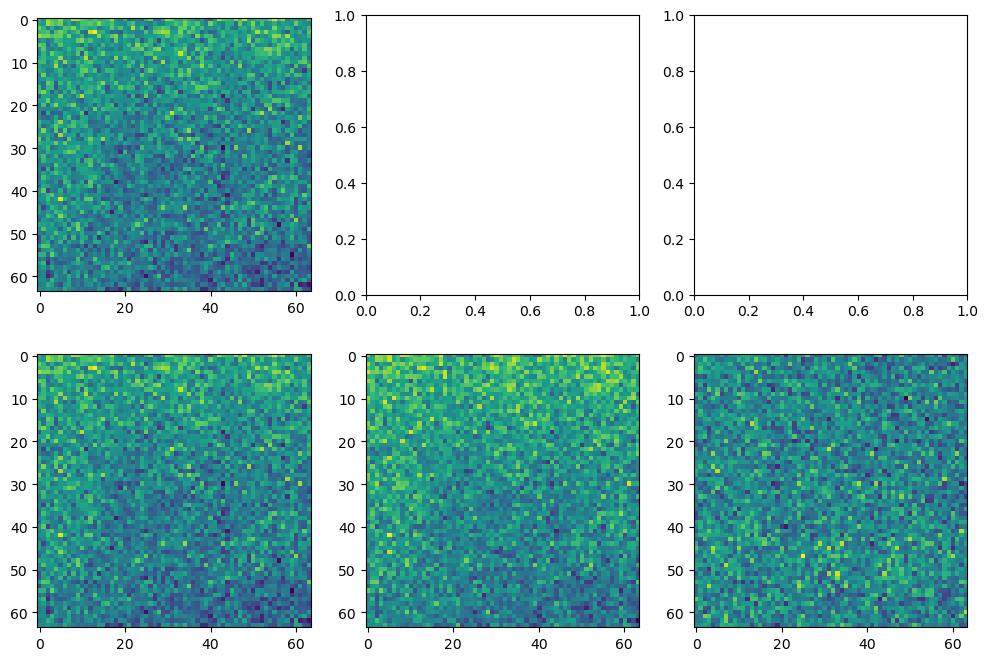

In [18]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
ncols = max(len(inp_tmp),3)
nrows = 2
_,ax = plt.subplots(figsize=(4*ncols,4*nrows),ncols=ncols,nrows=nrows)
for i in range(len(inp_tmp)):
    ax[0,i].imshow(inp_tmp[i])

ax[1,0].imshow(tar_tmp[0]+tar_tmp[1])
ax[1,1].imshow(tar_tmp[0])
ax[1,2].imshow(tar_tmp[1])


In [19]:
from denoisplit.analysis.stitch_prediction import stitch_predictions
from denoisplit.analysis.mmse_prediction import get_dset_predictions
# from denoisplit.analysis.stitch_prediction import get_predictions as get_dset_predictions

pred_tiled, rec_loss, logvar, patch_psnr_tuple = get_dset_predictions(model, val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=mmse_count,
                                                model_type = config.model.model_type,
                                              )
tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp) )

100%|██████████| 1323/1323 [00:26<00:00, 50.05it/s]

Patch wise PSNR, as computed during training [27.29 23.84] 25.564999999999998


In [20]:
np.mean(rec_loss)

-0.33665746

In [21]:
# Patch wise PSNR, as computed during training [ 4.71 23.01] 13.860000000000001


In [22]:
len(val_dset)

10584

In [23]:
idx_list = np.where(logvar.squeeze() < -6)[0]
if len(idx_list) > 0:
    plt.imshow(val_dset[idx_list[0]][1][1])

In [24]:
len(val_dset)

10584

/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

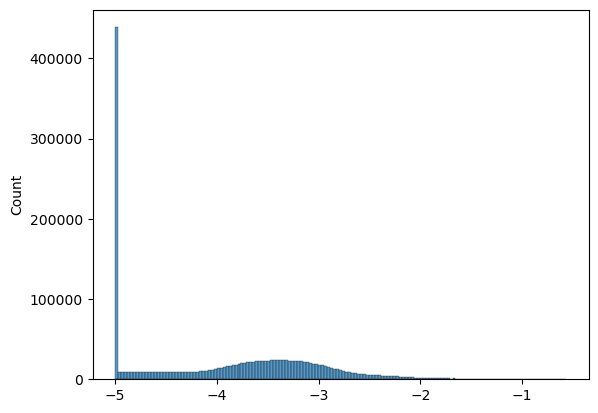

In [25]:
import seaborn as sns
sns.histplot(logvar[::50].squeeze().reshape(-1,))

In [26]:
print(np.quantile(rec_loss, [0,0.01,0.5, 0.9,0.99,0.999,1]).round(2))

[-1.35 -1.34 -0.44  0.44  2.92  7.13  8.32]


In [27]:
pred_tiled.shape

(10584, 2, 64, 64)

In [28]:
len(val_dset)

10584

In [29]:
if pred_tiled.shape[-1] != val_dset.get_img_sz():
    pad = (val_dset.get_img_sz() - pred_tiled.shape[-1] )//2
    pred_tiled = np.pad(pred_tiled, ((0,0),(0,0),(pad,pad),(pad,pad)))

pred = stitch_predictions(pred_tiled,val_dset, smoothening_pixelcount=0)

In [30]:
pred_tiled.shape

(10584, 2, 64, 64)

In [31]:
pred.shape

(6, 2720, 2720, 2)

In [32]:
pred[np.isnan(pred)] = 0

In [33]:
def print_ignored_pixels():
    ignored_pixels = 1
    while(pred[0,-ignored_pixels:,-ignored_pixels:,].std() ==0):
        ignored_pixels+=1
    ignored_pixels-=1
    print(f'In {pred.shape}, last {ignored_pixels} many rows and columns are all zero.')
    return ignored_pixels

actual_ignored_pixels = print_ignored_pixels()

In (6, 2720, 2720, 2), last 32 many rows and columns are all zero.


## Ignore the pixels which are present in the last few rows and columns. 
1. They don't come in the batches. So, in prediction, they are simply zeros. So they are being are ignored right now. 
2. For the border pixels which are on the top and the left, overlapping yields worse performance. This is becuase, there is nothing to overlap on one side. So, they are essentially zero padded. This makes the performance worse. 

In [34]:
actual_ignored_pixels

32

In [35]:
ignored_last_pixels = 32 if config.data.data_type in [DataType.OptiMEM100_014,
                                                      DataType.SemiSupBloodVesselsEMBL, 
                                                      DataType.Pavia2VanillaSplitting,
                                                      DataType.ExpansionMicroscopyMitoTub,
                                                      DataType.ShroffMitoEr,
                                                      DataType.HTIba1Ki67] else 0
ignore_first_pixels = 0

assert actual_ignored_pixels <= ignored_last_pixels, f'Set ignored_last_pixels={actual_ignored_pixels}'
print(ignored_last_pixels)

32


In [36]:
tar = val_dset._data
def ignore_pixels(arr):
    if ignore_first_pixels:
        arr = arr[:,ignore_first_pixels:,ignore_first_pixels:]
    if ignored_last_pixels:
        arr = arr[:,:-ignored_last_pixels,:-ignored_last_pixels]
    return arr

pred = ignore_pixels(pred)
tar = ignore_pixels(tar)


In [37]:
# from denoisplit.analysis.plot_utils import *
# def add_pixel_kde(ax,
#                   rect: List[float],
#                   data1: np.ndarray,
#                   data2: Union[np.ndarray, None],
#                   min_labelsize: int,
#                   color1='r',
#                   color2='black',
#                   color_xtick='white',
#                   label1='Target',
#                   label2='Predicted'):
#     """
#     Adds KDE (density plot) of data1(eg: target) and data2(ex: predicted) image pixel values as an inset
#     """
#     inset_ax = add_subplot_axes(ax, rect, facecolor="None", min_labelsize=min_labelsize)
    
#     inset_ax.tick_params(axis='x', colors=color_xtick)

#     sns.kdeplot(data=data1.reshape(-1, ), ax=inset_ax, color=color1, label=label1)
#     if data2 is not None:
#         sns.kdeplot(data=data2.reshape(-1, ), ax=inset_ax, color=color2, label=label2)
#     inset_ax.set_xlim(left=0)
#     xticks = inset_ax.get_xticks()
#     # inset_ax.set_xticks([xticks[0], xticks[-1]])
#     inset_ax.set_xticks([])
#     clean_for_xaxis_plot(inset_ax)


# ch1_pred_unnorm = pred[...,0]*sep_std[...,0].cpu().numpy() + sep_mean[...,0].cpu().numpy()
# ch2_pred_unnorm = pred[...,1]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy()

# inset_rect=[0.1,0.1,0.4,0.2]
# inset_min_labelsize=10
# color_ch_list=['goldenrod','cyan']

# _,ax = plt.subplots(figsize=(15,10),ncols=3,nrows=2)
# idx = 8
# pred1_crop  = ch1_pred_unnorm[idx,1116:1372,1064:1320].copy()
# pred2_crop  = ch2_pred_unnorm[idx,1116:1372,1064:1320].copy()
# pred1_crop[pred1_crop<0] = 0
# pred2_crop[pred2_crop<0] = 0

# tar1_crop   =  tar[idx,1116:1372,1064:1320,0]
# tar2_crop   =  tar[idx,1116:1372,1064:1320,1]

# ax[0,0].imshow(tar1_crop+tar2_crop)
# ax[0,1].imshow(tar1_crop)
# ax[0,2].imshow(tar2_crop)

# ax[1,0].imshow(pred1_crop+pred2_crop)
# ax[1,1].imshow(pred1_crop)
# ax[1,2].imshow(pred2_crop)
# clean_ax(ax)
# add_pixel_kde(ax[0,0], inset_rect, 
#               tar1_crop, 
#               tar2_crop, 
#               inset_min_labelsize,
#                 label1='Ch1', label2='Ch2', color1=color_ch_list[0], color2=color_ch_list[1])

# add_pixel_kde(ax[1,1], inset_rect, 
#               pred1_crop, 
#               tar1_crop, 
#               inset_min_labelsize,
#                 label1='Ch1', label2='Ch2', color1='red', color2=color_ch_list[0])
# add_pixel_kde(ax[1,2], inset_rect, 
#               pred2_crop, 
#               tar2_crop, 
#               inset_min_labelsize,
#                 label1='Ch1', label2='Ch2', color1='red', color2=color_ch_list[1])

In [38]:
from skimage.metrics import structural_similarity

def _avg_psnr(target, prediction, psnr_fn):
    output = np.mean([psnr_fn(target[i:i + 1], prediction[i:i + 1]).item() for i in range(len(prediction))])
    return round(output, 2)


def avg_range_inv_psnr(target, prediction):
    return _avg_psnr(target, prediction, RangeInvariantPsnr)


def avg_psnr(target, prediction):
    return _avg_psnr(target, prediction, PSNR)


def compute_masked_psnr(mask, tar1, tar2, pred1, pred2):
    mask = mask.astype(bool)
    mask = mask[..., 0]
    tmp_tar1 = tar1[mask].reshape((len(tar1), -1, 1))
    tmp_pred1 = pred1[mask].reshape((len(tar1), -1, 1))
    tmp_tar2 = tar2[mask].reshape((len(tar2), -1, 1))
    tmp_pred2 = pred2[mask].reshape((len(tar2), -1, 1))
    psnr1 = avg_range_inv_psnr(tmp_tar1, tmp_pred1)
    psnr2 = avg_range_inv_psnr(tmp_tar2, tmp_pred2)
    return psnr1, psnr2

def avg_ssim(target, prediction):
    ssim = [structural_similarity(target[i],prediction[i], data_range=(target[i].max() - target[i].min())) for i in range(len(target))]
    return np.mean(ssim),np.std(ssim)

In [39]:
sep_mean, sep_std = model.data_mean, model.data_std
if isinstance(sep_mean, dict):
    sep_mean = sep_mean['target']
    sep_std = sep_std['target']
    
sep_mean = sep_mean.squeeze()[None,None,None]
sep_std = sep_std.squeeze()[None,None,None]

tar_normalized = (tar - sep_mean.cpu().numpy())/sep_std.cpu().numpy()
tar1 =tar_normalized[...,0]
tar2 =tar_normalized[...,1]

In [40]:
q_vals = [0.01, 0.1,0.5,0.9,0.95, 0.99,1]
print('Nuc:', np.quantile(tar_normalized[...,0], q_vals).round(2))
print('Tub:', np.quantile(tar_normalized[...,1], q_vals).round(2))

Nuc: [-0.71 -0.4   0.93  2.24  2.68  3.68  3.83]
Tub: [-1.13 -1.03 -0.65 -0.07  0.12  0.5   2.  ]


In [41]:
print('Nuc:', np.quantile(tar[...,0], q_vals))
print('Tub:', np.quantile(tar[...,1], q_vals))

Nuc: [ 237.  311.  624.  932. 1036. 1271. 1308.]
Tub: [138. 162. 252. 388. 433. 521. 875.]


/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

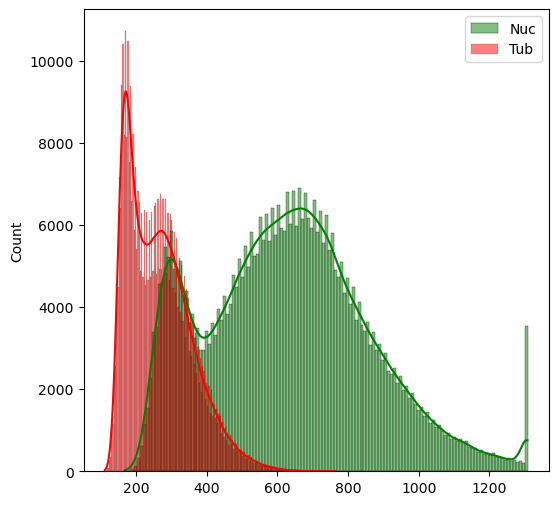

In [42]:
_,ax = plt.subplots(figsize=(6,6))
# sns.histplot(tar[:,...,0].reshape(-1,), color='g', label='Nuc')
# sns.histplot(tar[:,...,1].reshape(-1,), color='r', label='Tub')

sns.histplot(tar[:,::10,::10,0].reshape(-1,), color='g', label='Nuc', kde=True)
sns.histplot(tar[:,::10,::10,1].reshape(-1,), color='r', label='Tub', kde=True)
ax.legend()

In [43]:
# from denoisplit.data_loader.schroff_rawdata_loader import mito_channel_fnames
# from denoisplit.core.tiff_reader import load_tiff
# import seaborn as sns

# fpaths = [os.path.join(datapath, x) for x in mito_channel_fnames()]
# fpath = fpaths[0]
# print(fpath)
# img = load_tiff(fpaths[0])
# temp = img.copy()
# sns.histplot(temp[:,:,::10,::10].reshape(-1,))
# plt.hist(temp[:,:,::10,::10].reshape(-1,),bins=100)

4


(6, 2688, 2688, 2)

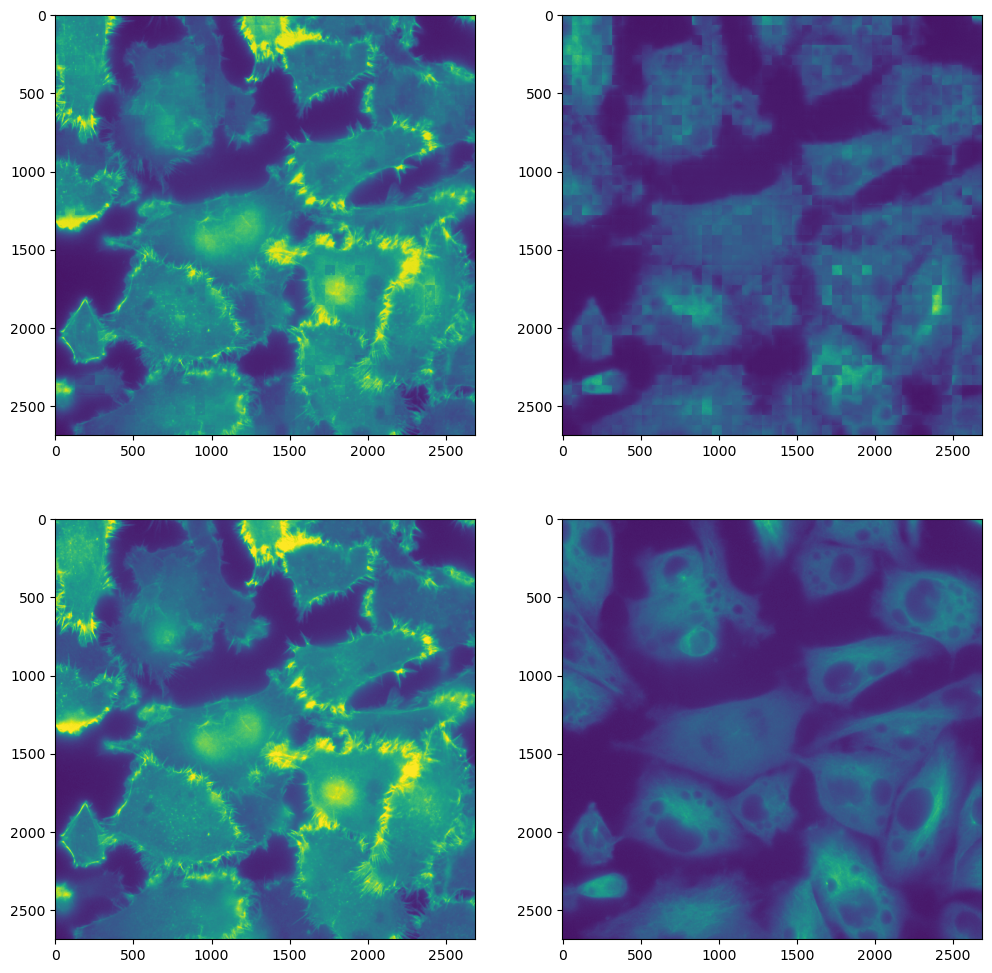

In [44]:
_,ax = plt.subplots(figsize=(12,12),ncols=2,nrows=2)
idx = np.random.randint(len(pred))
print(idx)
ax[0,0].imshow(pred[idx,:,:,0])
ax[0,1].imshow(pred[idx,:,:,1])
ax[1,0].imshow(tar1[idx,:,:])
ax[1,1].imshow(tar2[idx,:,:])

pred.shape

In [45]:
# pred is already normalized. no need to do it. 
pred1, pred2 = pred[...,0].astype(np.float32), pred[...,1].astype(np.float32)
pred_inp = (pred1 + pred2)/2

In [46]:
# ch1_pred_unnorm = pred[...,0]*sep_std[...,0].cpu().numpy() + sep_mean[...,0].cpu().numpy()
# ch2_pred_unnorm = pred[...,1]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy()
ch1_pred_unnorm = 2 * pred[...,0]*sep_std[...,0].cpu().numpy() + sep_mean[...,0].cpu().numpy()
ch2_pred_unnorm = 2 * pred[...,1]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy()

In [47]:
sep_mean

tensor([[[[404.2586, 404.2586]]]], device='cuda:0')

In [48]:
if config.model.model_type == ModelType.LadderVaeSemiSupervised:
    raise NotImplementedError("SSIM is incorrectly implemented here.")
    pred_inp = pred[...,2].astype(np.float32)
#     tar1 is the input. tar2 is the target. 
    rmse1 =np.sqrt(((pred1 - tar2)**2).reshape(len(pred1),-1).mean(axis=1))
    rmse2 =np.sqrt(((pred_inp - tar1)**2).reshape(len(pred2),-1).mean(axis=1)) 

    rmse = (rmse1 + rmse2)/2
    rmse = np.round(rmse,3)

    ssim1_mean, ssim1_std = avg_ssim(tar2, pred1)
    ssim2_mean, ssim2_std = avg_ssim(tar1, pred_inp)
    
    psnr1 = avg_psnr(tar2, pred1)
    psnr2 = avg_psnr(tar1, pred_inp)
    rinv_psnr1 = avg_range_inv_psnr(tar2, pred1)
    rinv_psnr2 = avg_range_inv_psnr(tar1, pred_inp)
    
else:
    rmse1 =np.sqrt(((pred1 - tar1)**2).reshape(len(pred1),-1).mean(axis=1))
    rmse2 =np.sqrt(((pred2 - tar2)**2).reshape(len(pred2),-1).mean(axis=1)) 

    rmse = (rmse1 + rmse2)/2
    rmse = np.round(rmse,3)
    psnr1 = avg_psnr(tar1, pred1) 
    psnr2 = avg_psnr(tar2, pred2)
    rinv_psnr1 = avg_range_inv_psnr(tar1, pred1)
    rinv_psnr2 = avg_range_inv_psnr(tar2, pred2)
    ssim1_mean, ssim1_std = avg_ssim(tar[...,0], ch1_pred_unnorm)
    ssim2_mean, ssim2_std = avg_ssim(tar[...,1], ch2_pred_unnorm)

In [49]:
tar.min()

100.0

In [50]:
tar[...,0].min()

153.0

In [51]:
tar1.min()

-1.0661422

In [52]:
print(f'{DataSplitType.name(eval_datasplit_type)}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}')
print('Rec Loss',np.round(rec_loss.mean(),3) )
print('RMSE', np.mean(rmse1).round(3), np.mean(rmse2).round(3), np.mean(rmse).round(3))
print('PSNR', psnr1, psnr2)
print('RangeInvPSNR',rinv_psnr1, rinv_psnr2 )
print('SSIM',round(ssim1_mean,3), round(ssim2_mean,3),'±',round((ssim1_std + ssim2_std)/2,4))
print()

Test_PNone_GNone_M1_Sk32
Rec Loss -0.337
RMSE 0.212 0.211 0.211
PSNR 27.25 22.99
RangeInvPSNR 27.34 23.07
SSIM 0.728 0.228 ± 0.0045



In [53]:
tar.shape

(6, 2688, 2688, 2)

In [54]:
ckpt_fpath

'/home/ashesh.ashesh/training/disentangle/2310/D3-M3-S0-L0/6/BaselineVAECL_best.ckpt'

In [55]:
import torch
import torch.optim as optim


def reload(model):
    checkpoint = torch.load(ckpt_fpath)
    _ = model.load_state_dict(checkpoint['state_dict'])

def train(cur_model, background_increment_factor=0.0, ch0_offset=0, val_idx=0, step_count=100, lr=1e-3,
          original_model=None,inner_pad=0, use_predicted_tar=True):
    if use_predicted_tar:
        raw_inp, _ = val_dset[val_idx]
        out, _ = cur_model(torch.Tensor(raw_inp[None]).cuda())
        raw_tar = get_img_from_forward_output(out, cur_model, unnormalized=True).detach().cpu().numpy()[0]
    else:
        raw_inp, raw_tar = val_dset[val_idx]
    
    raw_tar = raw_tar * (1+background_increment_factor)
    raw_tar = np.concatenate([raw_tar[:1] + ch0_offset, raw_tar[1:] - ch0_offset], axis=0)

    cur_model.train()
    cur_model.mode_pred = False
    inp = torch.Tensor(raw_inp[None]).cuda()
    tar = torch.Tensor(raw_tar[None]).cuda()
    tar = model.normalize_target(tar)
    optimizer = optim.Adamax(cur_model.parameters(), lr=lr, weight_decay=0)
    losses = []
    rec_losses = []
    reg_losses = []
    for _ in tqdm(range(step_count)):
        loss, loss_dict = one_step(cur_model, inp, tar, optimizer, original_model, inner_pad)
        losses.append(loss)
        rec_losses.append(loss_dict['rec_loss'])
        reg_losses.append(loss_dict['reg_loss'])
    return {'loss':losses, 'rec_loss':rec_losses, 'reg_loss':reg_losses}, (raw_inp, raw_tar)

def weight_regularization_loss(cur_model, original_model):
    original_model_dict = {k:v.detach() for k,v in original_model.named_parameters()}
    loss = 0
    for name, param in cur_model.named_parameters():
        loss += torch.mean(torch.abs(original_model_dict[name] - param))
    return loss/len(original_model_dict)

def one_step(cur_model, inp, tar, optimizer, original_model, inner_pad):
    out = cur_model(inp)[0]
    # ll = cur_model.likelihood(out, tar)[0]
    pred = get_img_from_forward_output(out, cur_model, unnormalized=False)
    rec_loss = (pred - tar)**2
    if inner_pad > 0:
        rec_loss = rec_loss[...,inner_pad:-inner_pad, inner_pad:-inner_pad]

    rec_loss = rec_loss.mean()
    reg_loss = 100 * weight_regularization_loss(cur_model, original_model) 
    loss = rec_loss + reg_loss * 0
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), {'rec_loss': rec_loss.item(), 'reg_loss': reg_loss.item()}

# pred, td_data = model(inpt)
# pred = get_img_from_forward_output(pred, model)

In [56]:
val_idx = 0
inp, tar = val_dset[val_idx]

In [57]:
print(np.quantile(tar[0], [0.01,0.1, 0.2, 0.5, 0.9, 0.99]))
print(np.quantile(tar[1], [0.01,0.1, 0.2, 0.5, 0.9, 0.99]))

[637.95 705.   733.   788.   889.   992.05]
[208.   234.   246.   272.   315.   352.05]


In [58]:
from copy import deepcopy
def get_cur_model():
    skip_updates_to = ['top_down_layers.0', 'likelihood', 'final_top_down']
    reload(model)
    cur_model = deepcopy(model)
    for name, param in cur_model.named_parameters():
        if any([name.startswith(x) for x in skip_updates_to]):
            param.requires_grad = False
            # print(name, 'frozen')
    return cur_model

cur_model = get_cur_model()
val_idx = 0

loss_dict, inptar = train(cur_model, background_increment_factor = 0, ch0_offset=100, step_count=20, lr=1e-4,
                       original_model=model,val_idx=val_idx, inner_pad=inp.shape[-1]//4)

100%|██████████| 20/20 [00:01<00:00, 12.53it/s]


Text(0.5, 1.0, 'pred now')

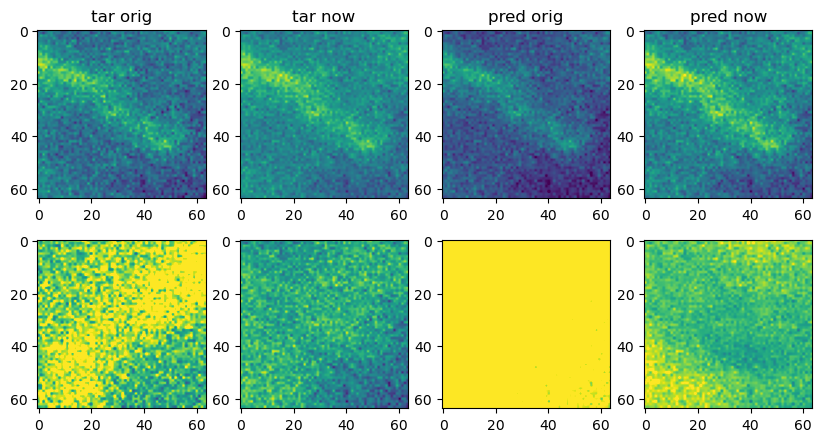

In [59]:
out, _ = cur_model(torch.Tensor(inp[None]).cuda())
pred_now = get_img_from_forward_output(out, cur_model, unnormalized=True).detach().cpu().numpy()[0]
out, _ = model(torch.Tensor(inp[None]).cuda())
pred_orig = get_img_from_forward_output(out, model, unnormalized=True).detach().cpu().numpy()[0]


tar_now = inptar[1]
vmin0 = min(tar_now[0].min(), tar[0].min())
vmax0 = max(tar_now[0].max(), tar[0].max())
vmin1 = min(tar_now[1].min(), tar[1].min())
vmax1 = min(tar_now[1].max(), tar[1].max())

_,ax = plt.subplots(ncols=4,nrows=2, figsize=(10,5))
ax[0,0].imshow(tar[0], vmin=vmin0, vmax=vmax0)
ax[0,1].imshow(tar_now[0], vmin=vmin0, vmax=vmax0)
ax[0,2].imshow(pred_orig[0], vmin=vmin0, vmax=vmax0)
ax[0,3].imshow(pred_now[0], vmin=vmin0, vmax=vmax0)

ax[1,0].imshow(tar[1], vmin=vmin1, vmax=vmax1)
ax[1,1].imshow(tar_now[1], vmin=vmin1, vmax=vmax1)
ax[1,2].imshow(pred_orig[1], vmin=vmin1, vmax=vmax1)
ax[1,3].imshow(pred_now[1], vmin=vmin1, vmax=vmax1)
ax[0,0].set_title('tar orig')
ax[0,1].set_title('tar now')
ax[0,2].set_title('pred orig')
ax[0,3].set_title('pred now')

In [60]:
def get_param_dict(model):
    param_dict = {}
    for k, v in model.named_parameters():
        param_dict[k] = v
    return param_dict

def get_sortedfirstk(dic, reverse=True, k=10):
    return sorted([(k,v) for k,v in dic.items()], key=lambda x: x[1], reverse=reverse)[:k]

def compare_two_models(m1, m2):
    m1_dict = get_param_dict(m1)
    m2_dict = get_param_dict(m2)
    maxpos_diff_dict = {}
    maxneg_diff_dict = {}
    avg_diff_dict = {}

    for k in m1_dict.keys():
        assert k in m2_dict.keys()
        diff = m1_dict[k].data - m2_dict[k].data
        maxpos_diff_dict[k] = diff.max().item()
        maxneg_diff_dict[k] = diff.min().item()
        avg_diff_dict[k] = diff.abs().mean().item()
    return maxpos_diff_dict, maxneg_diff_dict, avg_diff_dict


In [61]:
maxpos_diff_dict, maxneg_diff_dict, avg_diff_dict = compare_two_models(model, cur_model)

In [62]:
def pretty_print(arr):
    for k,v in arr:
        print(k,f'\t {v:.3f}')

# pretty_print(sorted([(k,v) for k,v in maxpos_diff_dict.items()], key=lambda x: x[1], reverse=True)[:10])
pretty_print(get_sortedfirstk(maxpos_diff_dict, reverse=True, k=10))
print('')
print('')
pretty_print(get_sortedfirstk(maxneg_diff_dict, reverse=False, k=10))
# pretty_print(sorted([(k,v) for k,v in maxneg_diff_dict.items()], key=lambda x: x[1], reverse=True)[-10:])

# plt.bar(range(len(maxpos_diff_dict)), list(maxpos_diff_dict.values()), align='center')
# plt.xticks(range(len(maxpos_diff_dict)), list(maxpos_diff_dict.keys()))

top_down_layers.1.deterministic_block.0.pre_conv.weight 	 0.001
top_down_layers.1.merge.layer.0.weight 	 0.001
top_down_layers.2.skip_connection_merger.layer.0.weight 	 0.001
top_down_layers.1.deterministic_block.0.res.block.8.conv.weight 	 0.001
top_down_layers.1.stochastic.conv_out.weight 	 0.001
top_down_layers.1.stochastic.conv_in_q.weight 	 0.001
top_down_layers.1.deterministic_block.0.res.block.2.weight 	 0.001
top_down_layers.1.skip_connection_merger.layer.0.weight 	 0.001
top_down_layers.1.merge.layer.1.block.2.weight 	 0.001
top_down_layers.1.deterministic_block.0.pre_conv.bias 	 0.001


top_down_layers.1.skip_connection_merger.layer.0.weight 	 -0.001
top_down_layers.1.deterministic_block.0.pre_conv.weight 	 -0.001
top_down_layers.1.merge.layer.0.weight 	 -0.001
top_down_layers.1.stochastic.conv_in_q.weight 	 -0.001
top_down_layers.2.deterministic_block.0.pre_conv.weight 	 -0.001
top_down_layers.3.deterministic_block.0.res.block.8.conv.weight 	 -0.001
top_down_layers.1.determi

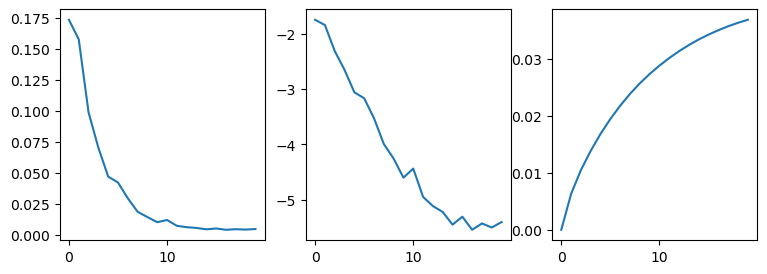

In [63]:
_,ax = plt.subplots(1,3, figsize=(9,3))
ax[0].plot(loss_dict['loss'])
ax[1].plot(np.log(loss_dict['rec_loss']))
ax[2].plot(loss_dict['reg_loss'])

## doing it for the whole validation dset. 

In [66]:
maxpos_val = {}
maxneg_val = {}
avg_val = {}

maxpos_counter = {}
maxneg_counter = {}
avg_counter = {}
dset_loss_dict = {'loss':[], 'rec_loss':[], 'reg_loss':[]}
topk = 10


for val_idx in range(len(val_dset)):
    inp, tar = val_dset[val_idx]
    reload(model)
    cur_model = deepcopy(model)
    loss_dict, inptar = train(cur_model, background_increment_factor = 0, ch0_offset=100, step_count=20, lr=1e-4,
                        original_model=model,val_idx=val_idx, inner_pad=inp.shape[-1]//4)
    dset_loss_dict['loss'] += loss_dict['loss']
    dset_loss_dict['rec_loss'] += loss_dict['rec_loss']
    dset_loss_dict['reg_loss'] += loss_dict['reg_loss']

    
    maxpos_diff_dict, maxneg_diff_dict, avg_diff_dict = compare_two_models(model, cur_model)
    for k,v in get_sortedfirstk(maxpos_diff_dict, k=topk, reverse=True):
        maxpos_val[k] = maxpos_val.get(k,0) + v
        maxpos_counter[k] = maxpos_counter.get(k,0) + 1
    
    for k,v in get_sortedfirstk(maxneg_diff_dict, k=topk, reverse=False):
        maxneg_val[k] = maxneg_val.get(k,0) + v
        maxneg_counter[k] = maxneg_counter.get(k,0) + 1
    
    for k,v in get_sortedfirstk(avg_diff_dict, k=topk, reverse=True):
        avg_val[k] = avg_val.get(k,0) + v
        avg_counter[k] = avg_counter.get(k,0) + 1

 75%|███████▌  | 15/20 [00:01<00:00, 11.86it/s]


KeyboardInterrupt: 

In [69]:
import pandas as pd
pd.DataFrame.from_dict(maxpos_val, orient='index').sort_values(by=0, ascending=False).head(10)

,0
top_down_layers.0.deterministic_block.0.pre_conv.weight,0.155636
top_down_layers.0.stochastic.conv_in_q.weight,0.147696
top_down_layers.0.stochastic.conv_out.weight,0.146811
top_down_layers.0.deterministic_block.0.pre_conv.bias,0.115411
top_down_layers.0.skip_connection_merger.layer.0.weight,0.106646
top_down_layers.0.merge.layer.0.weight,0.097583
top_down_layers.1.deterministic_block.0.pre_conv.weight,0.094387
likelihood.parameter_net.weight,0.061378
final_top_down.0.res.block.8.conv.weight,0.051760
bottom_up_layers.0.net_downsized.0.pre_conv.weight,0.041778


In [72]:
pd.DataFrame.from_dict(maxneg_counter, orient='index').sort_values(by=0, ascending=False).head(10)

,0
top_down_layers.0.deterministic_block.0.pre_conv.weight,97
top_down_layers.0.stochastic.conv_out.weight,96
top_down_layers.0.stochastic.conv_in_q.weight,96
top_down_layers.0.skip_connection_merger.layer.0.weight,77
top_down_layers.1.deterministic_block.0.pre_conv.weight,65
top_down_layers.0.merge.layer.0.weight,64
likelihood.parameter_net.weight,43
final_top_down.0.res.block.8.conv.weight,42
top_down_layers.0.deterministic_block.0.pre_conv.bias,41
top_down_layers.0.deterministic_block.0.res.block.8.conv.weight,29
